# Virus-Host Species Relation Extraction
## Notebook 3 - Generative Model Training
### UC Davis Epicenter for Disease Dynamics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

# Connect to the database backend and initalize a Snorkel session
#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

# gold (human-labeled) development set labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<175x1 sparse matrix of type '<class 'numpy.int32'>'
	with 114 stored elements in Compressed Sparse Row format>

## Part III: Fitting a Generative Model
Generative models estimate joint probability of x and y in order to generate new data.
<br>
<br>
In our case, the Generative Model will unify weak sources (the individual LFs) by maximizing the marginal likelihood of the LFs to learn model parameters. We estimate the accuracy of each LF.
<br>
<br>
Intuitively, the labeling functions are modeled based on how much they agree or disagree with each other. Once the model is trained, the outputs of the LFs are combined into a single, noise-aware training label set (called 'train_marginals') for our end extractor (the discriminative model, an LSTM network). 

In [2]:
# First, load label matrices from notebook 2
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs = [])
L_train = labeler.load_matrix(session, split=0)
L_dev = labeler.load_matrix(session, split=1)

### Generative Model
According to data programming, the generative model is used as a more sophisticated way to unify lower quality labeling functions. Since our labeling functions will not be perfect classifiers (some may be low-quality) their accuracies are modeled. 
<br>
<br>
**End goal**: produce a single set of denoised **training labels**, which are then used to train an end extraction model (LSTM) in Notebook 4. 
<br>
<br>
**Parameter Definitions**
<br>
epochs:     A single pass through all the data in your training set
<br>
step_size:  The factor by which we update model weights after computing the gradient
<br>
decay:      The rate our update factor dimishes (decay) over time.
<br>
<br>
While training the model, we should include dependencies between LFs that may affect output. The DependencySelector function identifies a set of likely dependencies for us.

In [3]:
# Detect dependencies between LFs
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold = 0.1)
len(deps)

68

#### Testing different hyperparameters to find the best accuracy
We use a grid search to tune hyperparameters, optimizing the model
<br>
<br>
#### Definitions:
- **Precision**: How often is the model correct when it predicts positive? 
<br>
<br>
$$Precision = \frac{truepositives}{truepositives + falsepositives}$$
<br>
<br>
- **Recall**: Helps when the cost of false negatives is high. A lower recall means there are more false negatives.
<br>
<br>
$$Recall = \frac{truepositives}{truepositives + falsenegatives}$$
<br>
<br>
- **F-1**: Overall measure of a model's accuracy, combining precision and recall. A good F-1 score means low false positives and low false negatives. The higher the score, the better (a perfect model having F-1 score of 1)

In [4]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch

param_ranges = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6, 0.1/L_train.shape[0]],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50, 100],
    'reg_param' : [1e-3],
    'deps': [deps]
}

model_class_params = {'lf_propensity' : True}

searcher = RandomSearch(GenerativeModel, param_ranges, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev)
run_stats

[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03, deps = {(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0), (4, 9, 0), (6, 7, 0), (2, 8, 0), (11, 13, 0), (8, 9, 0), (6, 10, 0), (10, 15, 0), (3, 4, 0), (4, 14, 0), (1, 3, 0), (2, 3, 0), (0, 5, 0), (14, 15, 0), (2, 14, 0), (1, 14, 0), (12, 15, 0), (0, 2, 0), (2, 4, 0), (1, 4, 0), (10, 11, 0), (6, 14, 0), (1, 9, 0), (5, 14, 0), (0, 15, 0), (2, 9, 0), (4, 10, 0), (8, 10, 0), (10, 12, 0), (6, 11, 0), (3, 7, 0), (2, 10, 0), (4, 15, 0), (1, 2, 0), (0, 6, 0), (9, 15, 0), (7, 14, 0), (0, 9, 0), (2, 15, 0), (5, 10, 0), (0, 3, 0), (9, 10, 0), (8, 14, 0), (6, 15, 0), (1, 8, 0), (12, 13, 0), (2, 6, 0), (1, 6, 0), (4, 6, 0), (6, 8, 0), (7, 10, 0), (10, 14, 0), (0, 7, 0), (9, 14, 0), (7, 9, 0), (0, 10, 0), (13, 15, 0), (1, 12, 0), (5, 9, 0), (0, 4, 0), (5, 6, 0), (6, 12, 0), (1, 15, 0), (12, 14, 0), (11, 14, 0)}
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.7652173913043477
[GenerativeModel] Model saved as <Ge

,step_size,decay,epochs,reg_param,deps,Prec.,Rec.,F-1
1,0.000028,0.95,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.785714,0.771930,0.778761
0,0.000010,0.90,50,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.758621,0.771930,0.765217
2,0.000010,0.95,50,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.758621,0.771930,0.765217
4,0.000001,0.95,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.758621,0.771930,0.765217
3,0.000100,0.90,100,0.001,"{(4, 7, 0), (6, 9, 0), (1, 10, 0), (0, 14, 0),...",0.800000,0.666667,0.727273


The searcher selected the optimal model with the optimal hyperparameters and included dependencies.

In [5]:
# The marginal predictions of the training labels
train_marginals = gen_model.marginals(L_train)

In [6]:
len(train_marginals)

3631

Let's visually explore the distribution of predicted training marginals. 
<br>
**Ideally, there should get a bimodal distribution with large separation between each peaks**

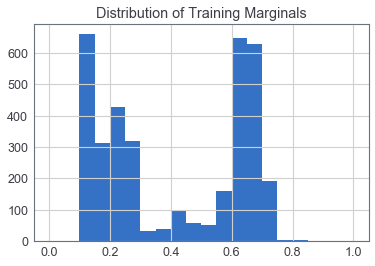

In [7]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.title('Distribution of Training Marginals')
plt.show()

The X axis is probability of classifying as positive or negative label (So a 0.5 would not be classified as anything). Based on shape above, ideally there are more values on the ends which indicate good coverage on both the positive and negative side.

In [8]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_detect,0,0.061966,0.061966,0.017075
LF_infect,1,0.054530,0.054530,0.016524
LF_isolate,2,0.070504,0.070504,0.024511
LF_positive,3,0.165795,0.165795,0.047645
LF_positive2,4,0.046268,0.046268,0.008813
LF_misc,5,0.254751,0.247315,0.155605
LF_v_cause_h,6,0.006059,0.006059,0.001102
LF_v_h,7,0.259157,0.138529,0.003305
LF_h_v,8,0.182319,0.066648,0.000000
LF_other_verbs,9,0.062793,0.062242,0.022308


### Checking performance against development set labels

We will run the labeler on the development set, load in hand labels, then evaluate LF performance.

#### Model Accuracies

In [9]:
L_dev.lf_stats(session, L_gold_dev)

C:\Users\erica\Anaconda3\envs\snorkel\lib\site-packages\snorkel\annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_detect,0,0.080000,0.080000,0.000000,8,0,0,0,1.0
LF_infect,1,0.057143,0.057143,0.005714,10,0,0,0,1.0
LF_isolate,2,0.005714,0.005714,0.000000,0,0,0,0,NaN
LF_positive,3,0.142857,0.142857,0.005714,18,0,0,0,1.0
LF_positive2,4,0.051429,0.051429,0.000000,5,0,0,0,1.0
LF_misc,5,0.234286,0.234286,0.085714,30,0,0,0,1.0
LF_v_cause_h,6,0.011429,0.011429,0.000000,2,0,0,0,1.0
LF_v_h,7,0.365714,0.154286,0.000000,45,0,0,0,1.0
LF_h_v,8,0.274286,0.171429,0.000000,43,0,0,0,1.0
LF_other_verbs,9,0.262857,0.240000,0.120000,12,0,0,0,1.0


In [10]:
# Generative Model Metrics
dev_marginals = gen_model.marginals(L_dev)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.772
Neg. class accuracy: 0.607
Precision            0.786
Recall               0.772
F1                   0.779
----------------------------------------
TP: 88 | FP: 24 | TN: 37 | FN: 26



In [11]:
# The sets tp, fp, tn, fn that come from the model error analysis can be viewed in the Viewer just like in intro. tutorial 2.

In [12]:
# view false positives
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(fp, session, height = 350)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[7, 8], [22, 23], [16, 17]], [[6], [18, 19, 20], [1, 3]], [[14], [5, 21], [4]], [[0…

In [13]:
# Save training labels to use in end extraction model
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 3631 marginals
Wall time: 6.11 s
